In [1]:
import os
import io
import re
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import ShuffleSplit
from nltk.corpus import stopwords
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# **Declare the paths**

In [2]:
path = "/content/drive/MyDrive/ml1/vaccine_train_set.csv"
train = pd.read_csv(path)
path = "/content/drive/MyDrive/ml1/vaccine_validation_set.csv"
test = pd.read_csv(path)

Rename the first column from Unnamed: 0 to id to be more understandable

In [3]:
train = train.rename(columns={'Unnamed: 0': 'id'})
test = test.rename(columns={'Unnamed: 0': 'id'})

# Drop null values (if there are any)

In [4]:
print(train.isnull().sum())
print(test.isnull().sum())

#both have no null values so we dont have to drop them

id       0
tweet    0
label    0
dtype: int64
id       0
tweet    0
label    0
dtype: int64


# **Pre-processing (cleaning the data)**


First change all letters to lowercase,remove http links, replace - and _ with a space " " because a lot of people on the internet use it instead of a space,replace 's with is n't with not 're with  are and remove all special characters with form : \x..(example \xa0) and \u.... (example \u0111) and at last remove all special characters and digits

In [5]:
def cleaning(df):
    df['tweet'] = df['tweet'].str.lower()
    df['tweet'] = df['tweet'].str.replace('http\S+|www.\S+', '', case=False)     
    df['tweet'] = df['tweet'].str.replace('"','')                       
    df['tweet'] = df['tweet'].str.replace("-",' ')                              
    df['tweet'] = df['tweet'].str.replace('.',' ')                  
    df['tweet'] = df['tweet'].str.replace("_",' ')                                 
    df['tweet'] = df['tweet'].str.replace("'s",' is')                         
    df['tweet'] = df['tweet'].str.replace("n't",' not')                            
    df['tweet'] = df['tweet'].str.replace("'re",' are')                               
    df['tweet'] = df['tweet'].str.replace(r'\\n', '', regex=True)
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\\x..','',x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\\u....','',x))
    df['tweet'] = df['tweet'].map(lambda x: re.sub(r'\W+', ' ', x))
    df['tweet'] = df['tweet'].map(lambda x: re.sub(r'[0-9]+', '', x))
    return df

# **Remove stopwords**

In [6]:
def remove_stopwords(df):
  stop = stopwords.words('english')
  df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  return df

# **Stemming and Lemmatizing**

In [7]:
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
def convert(text):
  lemmatized_text = []
  for i in text:
    lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(i,pos="v")))
  return ' '.join(lemmatized_text)

def stem_lem(df_column):
  unstemmed = df_column.str.split()
  stemmed = unstemmed.apply(lambda x: [stemmer.stem(y) for y in x])
  lemma = stemmed.apply(lambda x: convert(x)).to_frame()
  return lemma


In [8]:
#CLEANING
train = cleaning(train)
test = cleaning(test)

#STOPWORDS
train = remove_stopwords(train)
test = remove_stopwords(test)

#STEMMING AND LEMMATIZING                         #removed stemming and lemmatizing because we had worse scores
#train['tweet'] = stem_lem(train['tweet'])
#test['tweet'] = stem_lem(test['tweet'])


In [9]:
X_train = train['tweet']
Y_train = train['label']
X_test = test['tweet']
Y_test = test['label']

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5)
#vectorizer = HashingVectorizer(ngram_range=(1, 2))
#vectorizer = CountVectorizer(ngram_range=(1, 2))                          

tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

# **LEARNING CURVE**

In [33]:
train_sizes = np.linspace(100,len(train),20,dtype=int)       #split train data into 20 equal parts (starting with 100)


f1_trains = []                                                          #here we will be saving train scores of f1 metric 
f1_tests = []                                                           #here we will be saving test scores of f1 metric

for sizes in train_sizes:
  newX = tfidf_train[1:sizes]
  newY = Y_train[1:sizes]

  #decided to use C=0.5 because train score and test score difference was about 6%(0.8 vs 0.74) meaning both there is no overfitting and we have the best possible test score
  RegMax = LogisticRegression(multi_class="multinomial",C=0.5,solver='lbfgs',max_iter=10000).fit(newX,newY)          

  predictions = RegMax.predict(newX)
  f1 = f1_score(newY,predictions,average='micro')
  f1_trains.append(f1)

  predictions = RegMax.predict(tfidf_test)
  f1 = f1_score(Y_test,predictions,average='micro')
  f1_tests.append(f1)

print("F1 train score after training all data set : ","{:.2f}".format(f1_trains[19]))
print("F1 test score after training all data set : ","{:.2f}".format(f1_tests[19]))

F1 train score after training all data set :  0.80
F1 test score after training all data set :  0.74


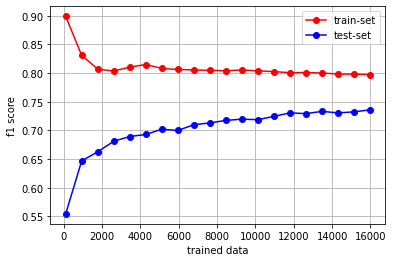

In [34]:
plt.plot(train_sizes, f1_trains, 'ro-',label="train-set")
plt.plot(train_sizes, f1_tests, 'bo-',label="test-set")
plt.xlabel('trained data')
plt.ylabel('f1 score')
plt.grid(b=True)
plt.legend(loc="best")
plt.show()

In [35]:
RegMax = LogisticRegression(multi_class="multinomial",C=0.5,solver='lbfgs',max_iter=10000).fit(tfidf_train,Y_train)     

predictions = RegMax.predict(tfidf_test)
rec = "{:.2f}".format(recall_score(Y_test,predictions,average='weighted'))
pre = "{:.2f}".format(precision_score(Y_test,predictions,average='weighted'))
f1 = "{:.2f}".format(f1_score(Y_test,predictions,average='weighted'))

print("Test-set scores : Recall : ",rec, " precision : ",pre, " f1 : ", f1)

Test-set scores : Recall :  0.74  precision :  0.74  f1 :  0.73
